In [3]:
import os
import gdown
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Input, Dense, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [10]:
files_to_download = [
    {'id': '1XP7aWc8AqALFA5HofiC6FQOI5rJ6SVc9', 'name': 'Dataset.zip'},
    {'id': '1pzknl3RgnAmMEutPoKJ0iiPcDepDAN8y', 'name': 'idm_baru.csv'}
]

def download_file(file_id, output_file):
    download_url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(download_url, output_file, quiet=False)

for file in files_to_download:
    download_file(file['id'], file['name'])

with zipfile.ZipFile('Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall("Data/")

Downloading...
From: https://drive.google.com/uc?id=1XP7aWc8AqALFA5HofiC6FQOI5rJ6SVc9
To: d:\Pemrograman\ModelBPS\Dataset.zip
100%|██████████| 5.17M/5.17M [00:02<00:00, 1.81MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pzknl3RgnAmMEutPoKJ0iiPcDepDAN8y
To: d:\Pemrograman\ModelBPS\idm_baru.csv
100%|██████████| 74.1k/74.1k [00:00<00:00, 1.24MB/s]


In [11]:
day_path = 'Data/Dataset/Daylight'
night_path = 'Data/Dataset/NTL'
metadata = 'Data/idm_baru.csv'

In [12]:
idm_df = pd.read_csv(metadata)
idm_df.head()

,KABUPATEN,KECAMATAN,KODE BPS,DESA,IKS,IKE,IKL,IDM,KATEGORI IDM,BINARY STATUS
0,ACEH UTARA,SAWANG,1111010001,RISEH TUNONG,0.56,3667.00,3333.0,0.42,SANGAT TERTINGGAL,TERTINGGAL
1,ACEH UTARA,SAWANG,1111010002,GUNCI,7029.00,4167.00,3333.0,4843.00,SANGAT TERTINGGAL,TERTINGGAL
2,ACEH UTARA,SAWANG,1111010003,KUBU,6914.00,4667.00,4667.0,5416.00,TERTINGGAL,TERTINGGAL
3,ACEH UTARA,SAWANG,1111010004,BLANG CUT,6514.00,3333.00,4667.0,4838.00,SANGAT TERTINGGAL,TERTINGGAL
4,ACEH UTARA,SAWANG,1111010005,RISEH TEUNGOH,5714.00,0.45,5333.0,5183.00,TERTINGGAL,TERTINGGAL


In [13]:
idm_df_filtered = idm_df[['KODE BPS', 'KECAMATAN', 'DESA', 'BINARY STATUS']]
idm_df_filtered

,KODE BPS,KECAMATAN,DESA,BINARY STATUS
0,1111010001,SAWANG,RISEH TUNONG,TERTINGGAL
1,1111010002,SAWANG,GUNCI,TERTINGGAL
2,1111010003,SAWANG,KUBU,TERTINGGAL
3,1111010004,SAWANG,BLANG CUT,TERTINGGAL
4,1111010005,SAWANG,RISEH TEUNGOH,TERTINGGAL
...,...,...,...,...
846,1111041003,GEUREDONG PASE,KRUENG MBANG,TERTINGGAL
847,1111041002,GEUREDONG PASE,PULO MEURIA,TERTINGGAL
848,1111041001,GEUREDONG PASE,SUKA DAMAI,MAJU
849,1111022002,BANDA BARO,ALUE KEURINYAI,MAJU


In [19]:
def match_images_with_metadata(image_files, metadata, is_night=False):
    image_data = []
    for img_path in image_files:
        img_name = os.path.basename(img_path)
        if is_night:
            village_code = img_name.split('.')[0]
        else:
            village_code = img_name.split('-')[0]
        village_info = metadata[metadata['KODE BPS'] == int(village_code)]
        if not village_info.empty:
            kecamatan = village_info['KECAMATAN'].values[0]
            desa = village_info['DESA'].values[0]
            status = village_info['BINARY STATUS'].values[0]
            image_data.append({
                'filename': img_name,
                'filepath': img_path,
                'kecamatan': kecamatan,
                'desa': desa,
                'status': status
            })
    return pd.DataFrame(image_data)

In [15]:
day_files = []
for root, dirs, files in os.walk(day_path):
    for file in files:
        day_files.append(os.path.join(root, file))

day_files[:10]

['Data/Dataset/Daylight\\MAJU\\1111010008-l.png',
 'Data/Dataset/Daylight\\MAJU\\1111010008-s.png',
 'Data/Dataset/Daylight\\MAJU\\1111010023-l.png',
 'Data/Dataset/Daylight\\MAJU\\1111010023-s.png',
 'Data/Dataset/Daylight\\MAJU\\1111010024-l.png',
 'Data/Dataset/Daylight\\MAJU\\1111010024-s.png',
 'Data/Dataset/Daylight\\MAJU\\1111010027-l.png',
 'Data/Dataset/Daylight\\MAJU\\1111010027-s.png',
 'Data/Dataset/Daylight\\MAJU\\1111010034-l.png',
 'Data/Dataset/Daylight\\MAJU\\1111010034-s.png']

In [16]:
night_files = []
for root, dirs, files in os.walk(night_path):
    for file in files:
        night_files.append(os.path.join(root, file))

night_files[:10]

['Data/Dataset/NTL\\MAJU\\1111010008.png',
 'Data/Dataset/NTL\\MAJU\\1111010023.png',
 'Data/Dataset/NTL\\MAJU\\1111010024.png',
 'Data/Dataset/NTL\\MAJU\\1111010027.png',
 'Data/Dataset/NTL\\MAJU\\1111010034.png',
 'Data/Dataset/NTL\\MAJU\\1111020014.png',
 'Data/Dataset/NTL\\MAJU\\1111020019.png',
 'Data/Dataset/NTL\\MAJU\\1111020023.png',
 'Data/Dataset/NTL\\MAJU\\1111020025.png',
 'Data/Dataset/NTL\\MAJU\\1111020026.png']

In [20]:
day_images_metadata = match_images_with_metadata(day_files, idm_df_filtered)
day_images_metadata

,filename,filepath,kecamatan,desa,status
0,1111010008-l.png,Data/Dataset/Daylight\MAJU\1111010008-l.png,SAWANG,SAWANG,MAJU
1,1111010008-s.png,Data/Dataset/Daylight\MAJU\1111010008-s.png,SAWANG,SAWANG,MAJU
2,1111010023-l.png,Data/Dataset/Daylight\MAJU\1111010023-l.png,SAWANG,MEUNASAH PULO,MAJU
3,1111010023-s.png,Data/Dataset/Daylight\MAJU\1111010023-s.png,SAWANG,MEUNASAH PULO,MAJU
4,1111010024-l.png,Data/Dataset/Daylight\MAJU\1111010024-l.png,SAWANG,LHOK KUYUN,MAJU
...,...,...,...,...,...
1697,1111170010-s.png,Data/Dataset/Daylight\TERTINGGAL\1111170010-s.png,DEWANTARA,GEULUMPANG SULU BARAT,TERTINGGAL
1698,1111170014-l.png,Data/Dataset/Daylight\TERTINGGAL\1111170014-l.png,DEWANTARA,BANGKA JAYA,TERTINGGAL
1699,1111170014-s.png,Data/Dataset/Daylight\TERTINGGAL\1111170014-s.png,DEWANTARA,BANGKA JAYA,TERTINGGAL
1700,1111170015-l.png,Data/Dataset/Daylight\TERTINGGAL\1111170015-l.png,DEWANTARA,BLUKA TEUBAI,TERTINGGAL


In [22]:
night_images_metadata = match_images_with_metadata(night_files, idm_df_filtered, is_night=True)
night_images_metadata

,filename,filepath,kecamatan,desa,status
0,1111010008.png,Data/Dataset/NTL\MAJU\1111010008.png,SAWANG,SAWANG,MAJU
1,1111010023.png,Data/Dataset/NTL\MAJU\1111010023.png,SAWANG,MEUNASAH PULO,MAJU
2,1111010024.png,Data/Dataset/NTL\MAJU\1111010024.png,SAWANG,LHOK KUYUN,MAJU
3,1111010027.png,Data/Dataset/NTL\MAJU\1111010027.png,SAWANG,BABAH BULOH,MAJU
4,1111010034.png,Data/Dataset/NTL\MAJU\1111010034.png,SAWANG,ULEE GEUDONG,MAJU
...,...,...,...,...,...
846,1111170008.png,Data/Dataset/NTL\TERTINGGAL\1111170008.png,DEWANTARA,ULEE REULEUNG,TERTINGGAL
847,1111170009.png,Data/Dataset/NTL\TERTINGGAL\1111170009.png,DEWANTARA,LANCANG BARAT,TERTINGGAL
848,1111170010.png,Data/Dataset/NTL\TERTINGGAL\1111170010.png,DEWANTARA,GEULUMPANG SULU BARAT,TERTINGGAL
849,1111170014.png,Data/Dataset/NTL\TERTINGGAL\1111170014.png,DEWANTARA,BANGKA JAYA,TERTINGGAL


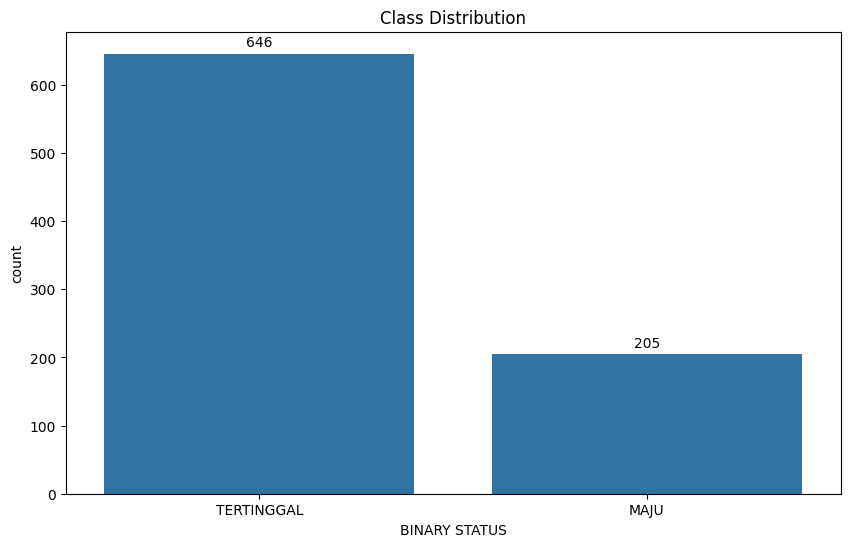

In [23]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='BINARY STATUS', data=idm_df_filtered)
plt.title('Class Distribution')
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

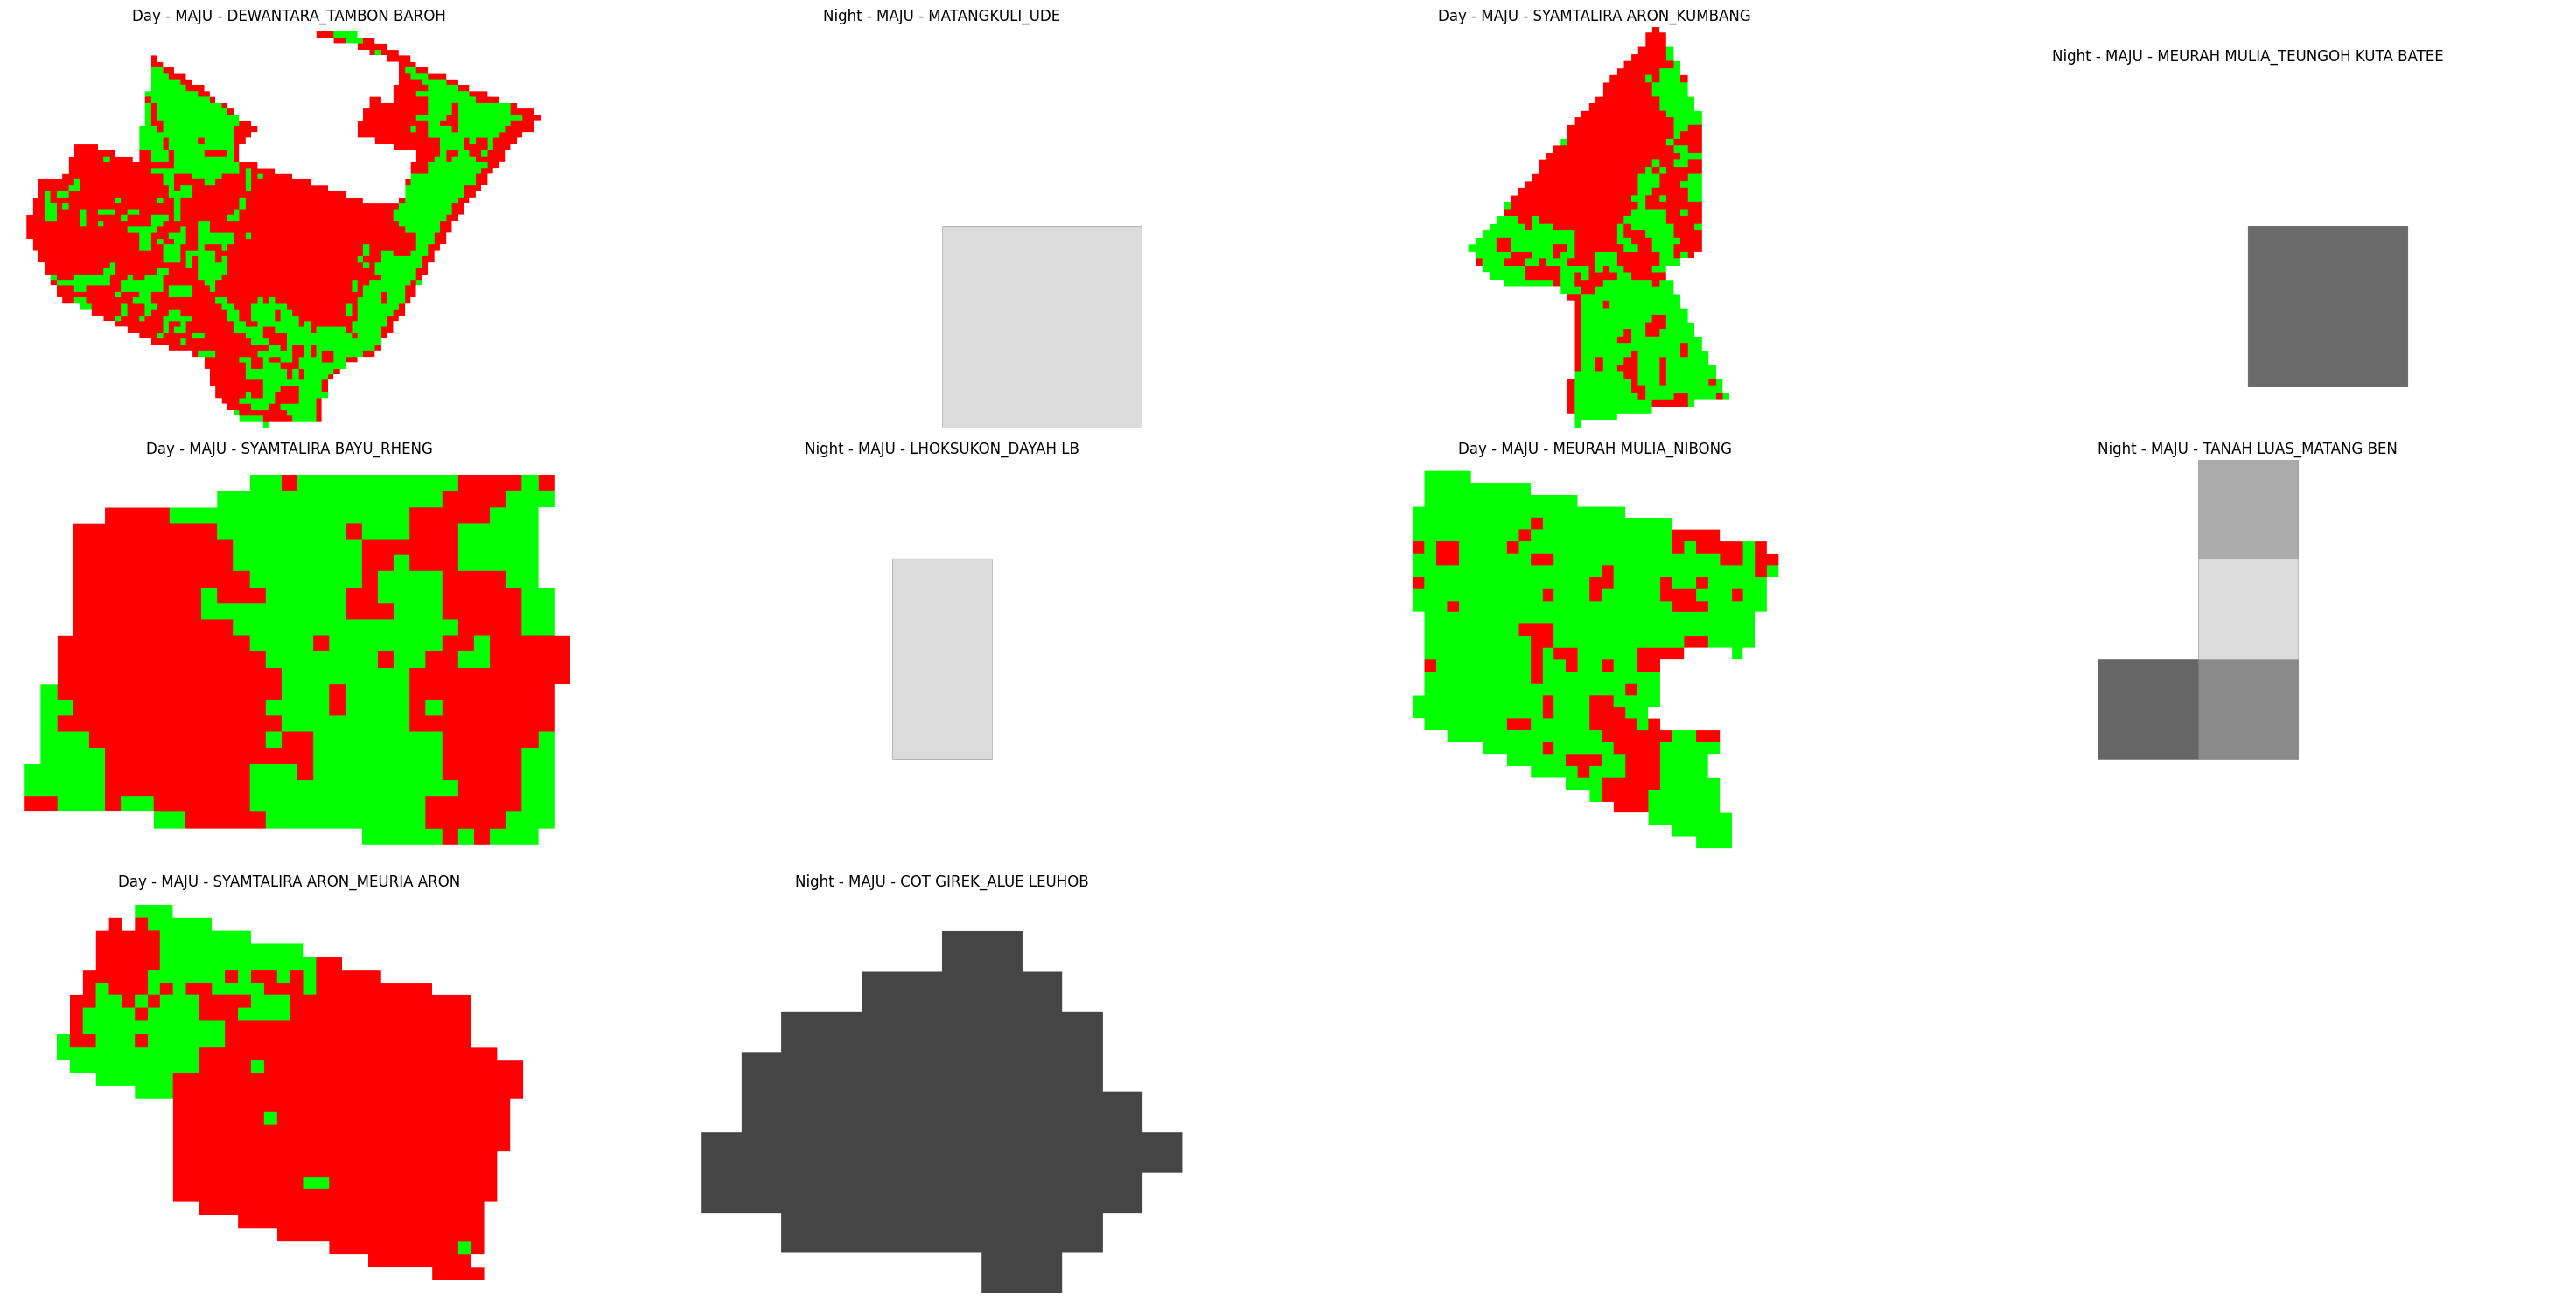

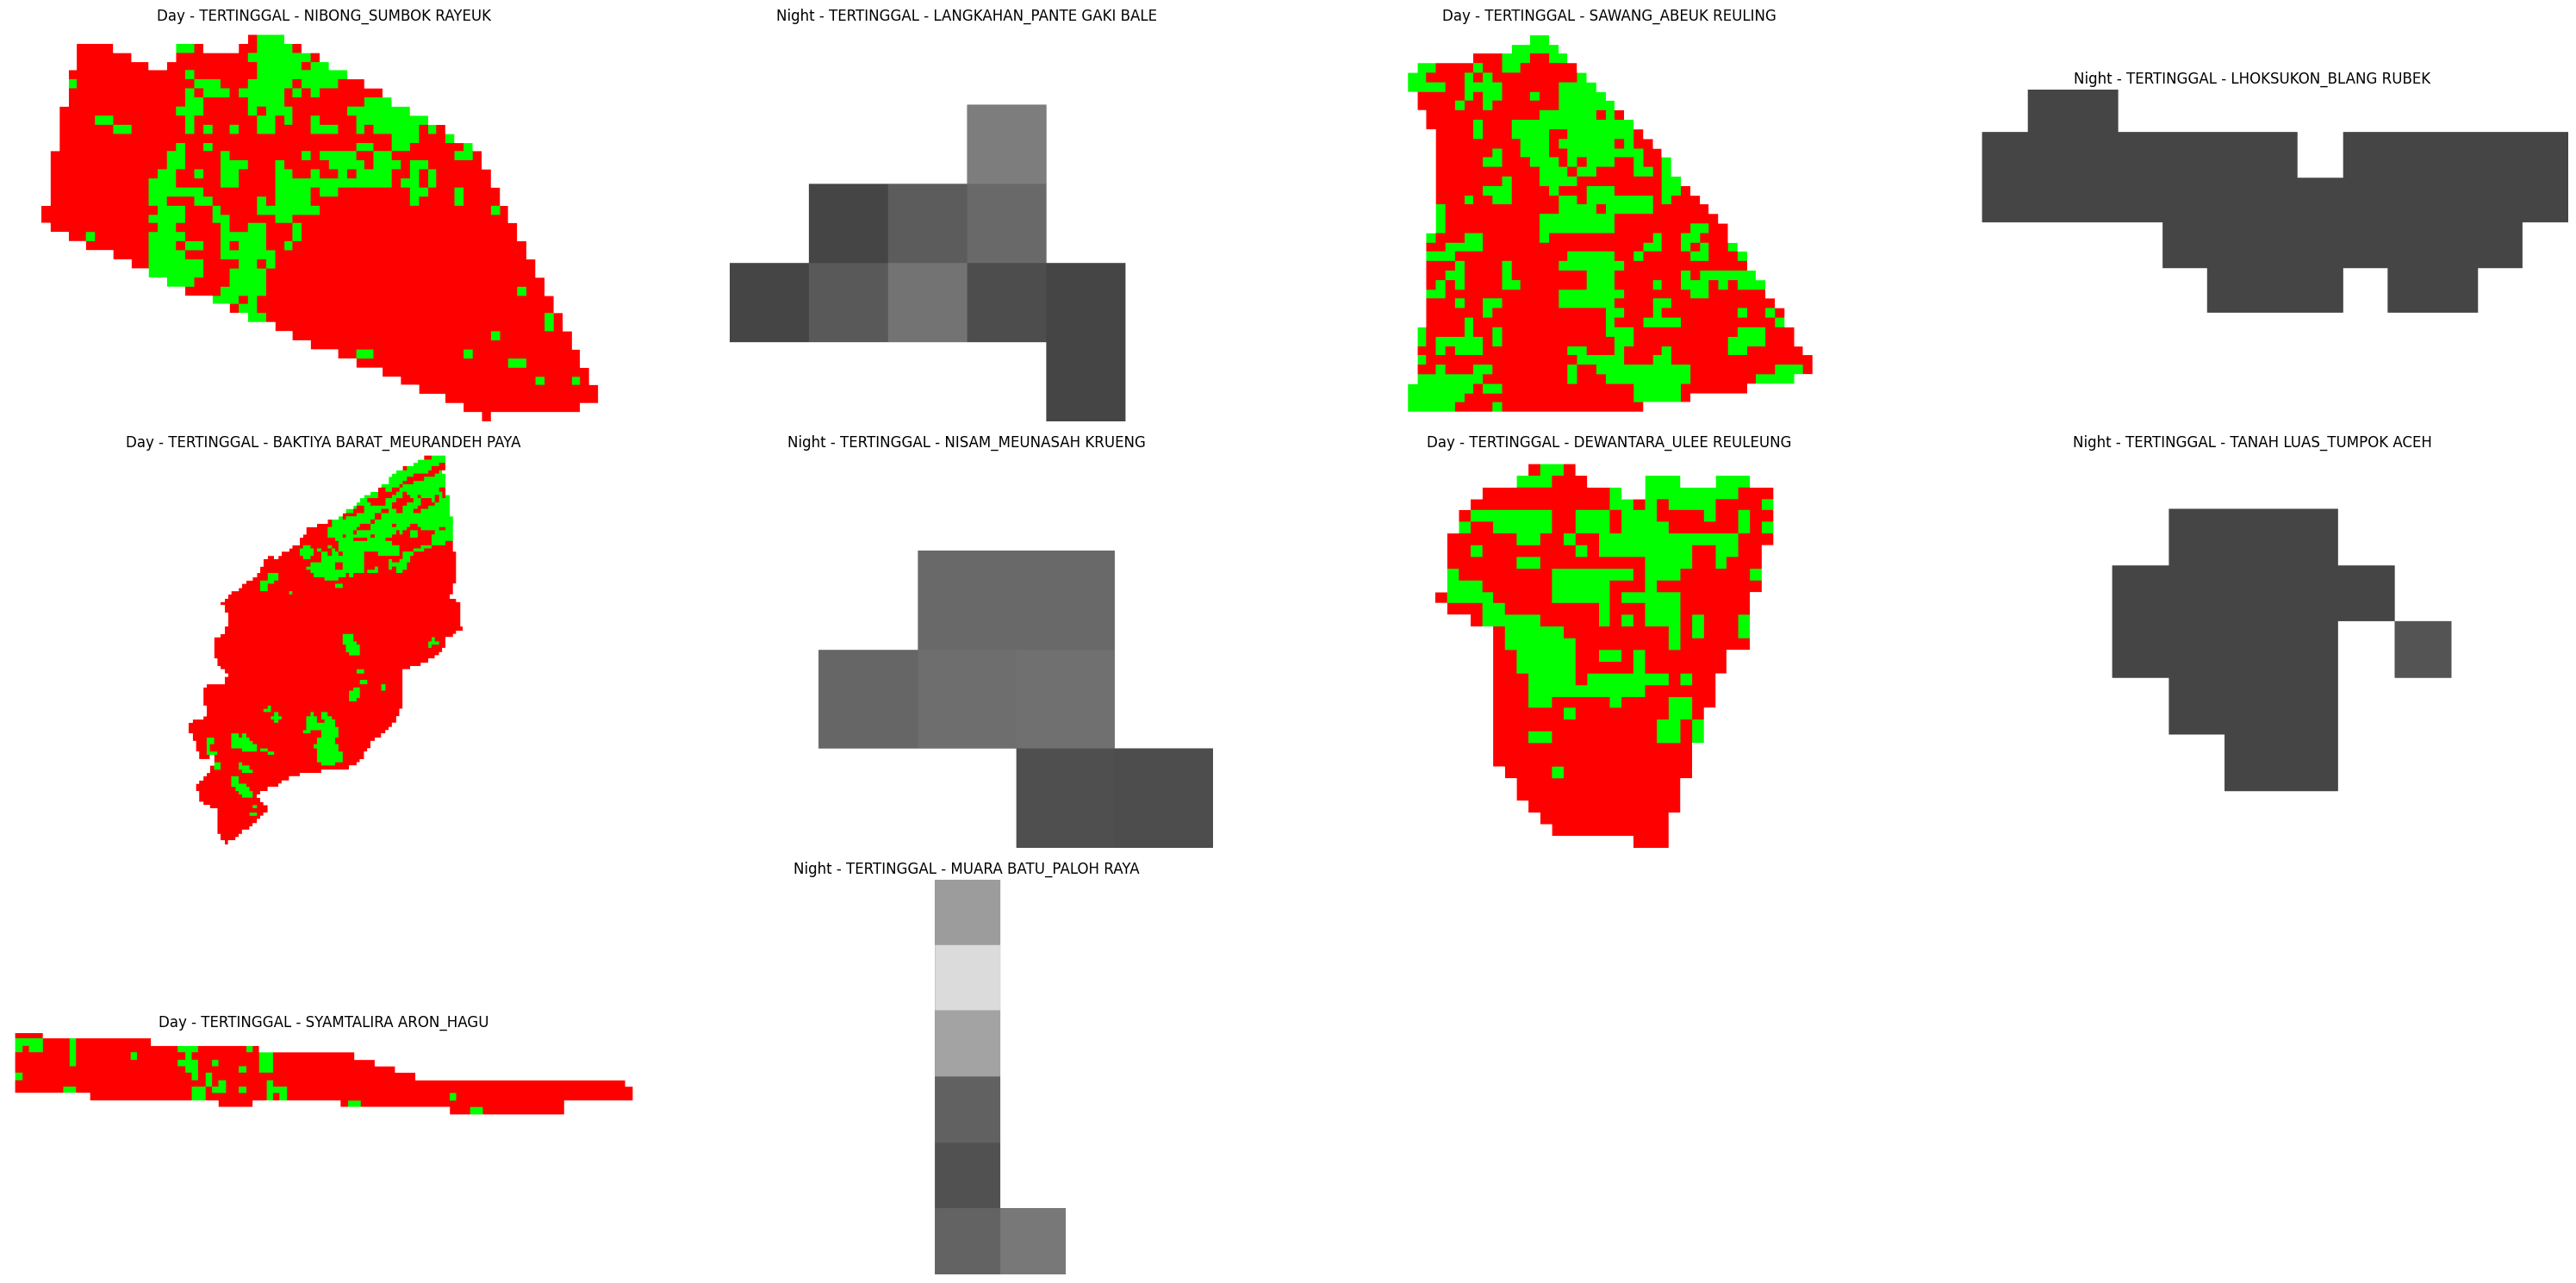

In [32]:
def show_sample_images(day_image_data, night_image_data, class_label, n=5, cols=2):
    class_images_day = day_image_data[day_image_data['status'] == class_label]
    class_images_night = night_image_data[night_image_data['status'] == class_label]
    
    sample_images_day = class_images_day.sample(n)
    sample_images_night = class_images_night.sample(n)
    
    rows = (n // cols) + (n % cols > 0)
    fig, axes = plt.subplots(rows, cols*2, figsize=(30, 5*rows))
    axes = axes.flatten()
    
    for i, ((_, day_row), (_, night_row)) in enumerate(zip(sample_images_day.iterrows(), sample_images_night.iterrows())):
        # Day images
        img_path_day = day_row['filepath']
        img_day = Image.open(img_path_day)
        ax_day = axes[i*2]
        ax_day.imshow(img_day)
        ax_day.set_title(f"Day - {class_label} - {day_row['kecamatan']}_{day_row['desa']}")
        ax_day.axis('off')
        
        # Night images
        img_path_night = night_row['filepath']
        img_night = Image.open(img_path_night)
        ax_night = axes[i*2 + 1]
        ax_night.imshow(img_night)
        ax_night.set_title(f"Night - {class_label} - {night_row['kecamatan']}_{night_row['desa']}")
        ax_night.axis('off')
    
    for ax in axes[len(sample_images_day)*2:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

show_sample_images(day_images_metadata, night_images_metadata, 'MAJU', n=5, cols=2)
show_sample_images(day_images_metadata, night_images_metadata, 'TERTINGGAL', n=5, cols=2)


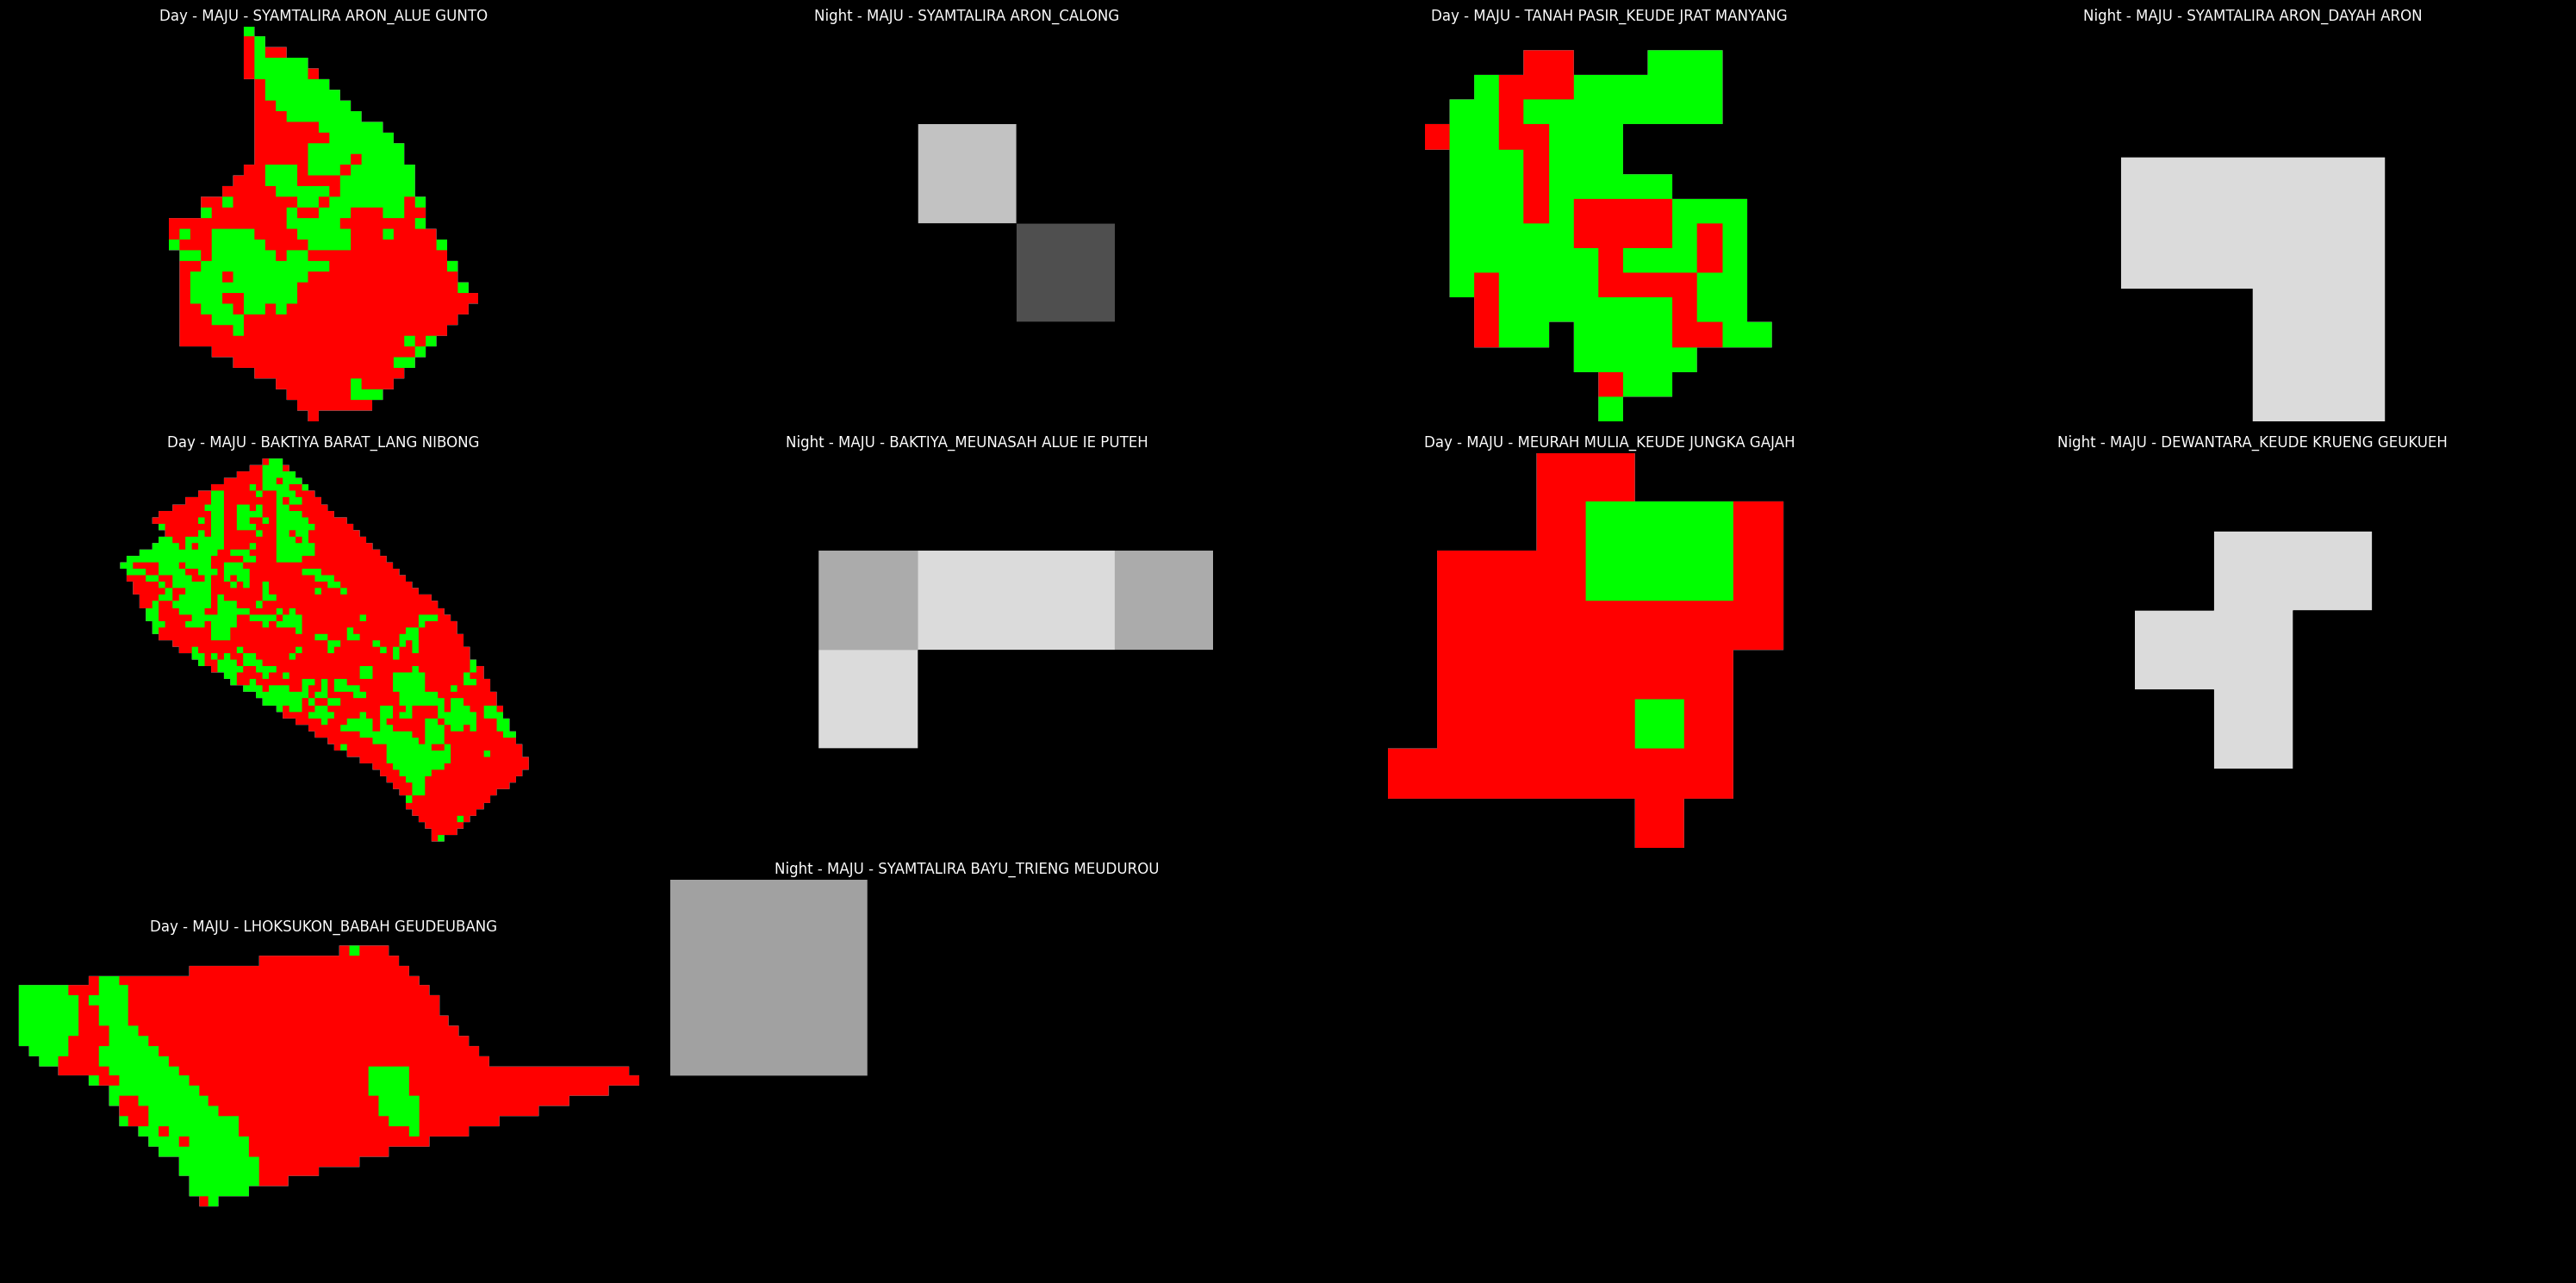

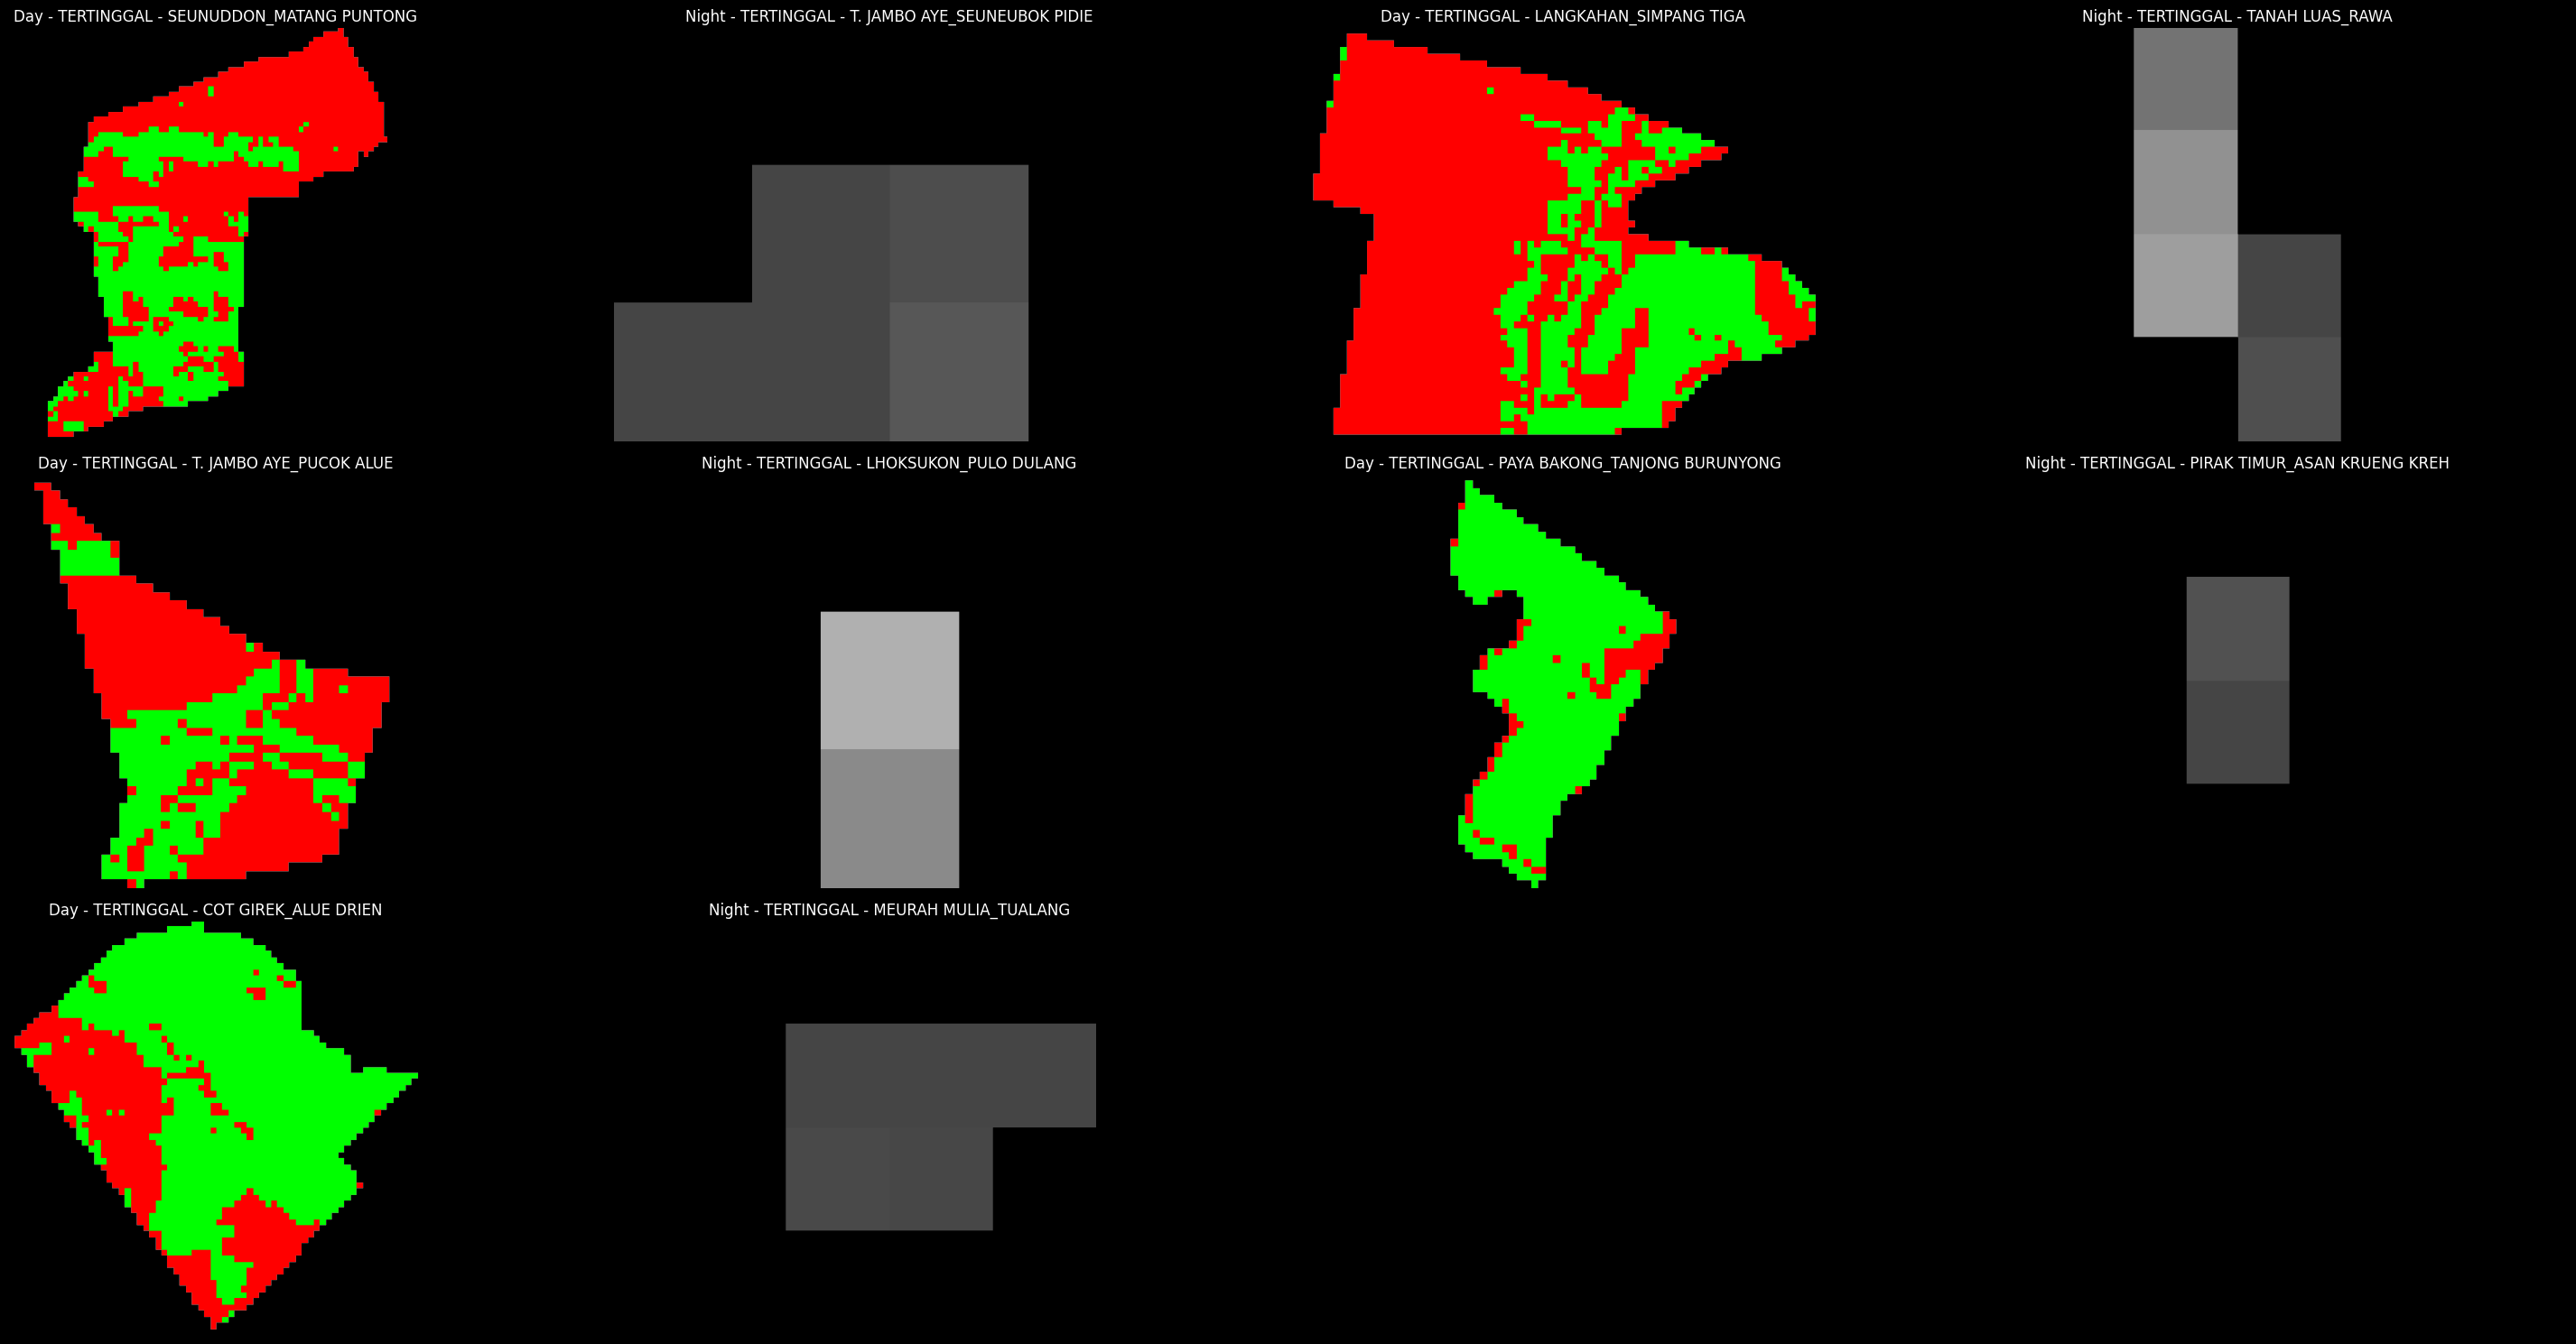

In [41]:
def show_sample_images_with_night(day_image_data, night_image_data, class_label, n=5, cols=2):
    class_images_day = day_image_data[day_image_data['status'] == class_label]
    class_images_night = night_image_data[night_image_data['status'] == class_label]
    
    sample_images_day = class_images_day.sample(n)
    sample_images_night = class_images_night.sample(n)
    
    rows = (n // cols) + (n % cols > 0)
    fig, axes = plt.subplots(rows, cols*2, figsize=(30, 5*rows), facecolor='black')  # cols*2 for day and night images side by side
    axes = axes.flatten()
    
    for i, ((_, day_row), (_, night_row)) in enumerate(zip(sample_images_day.iterrows(), sample_images_night.iterrows())):
        # Day images
        img_path_day = day_row['filepath']
        img_day = Image.open(img_path_day)
        ax_day = axes[i*2]
        ax_day.imshow(img_day)
        ax_day.set_title(f"Day - {class_label} - {day_row['kecamatan']}_{day_row['desa']}", color='white')
        ax_day.axis('off')
        
        # Night images
        img_path_night = night_row['filepath']
        img_night = Image.open(img_path_night)
        ax_night = axes[i*2 + 1]
        ax_night.imshow(img_night)
        ax_night.set_title(f"Night - {class_label} - {night_row['kecamatan']}_{night_row['desa']}", color='white')
        ax_night.axis('off')
    
    for ax in axes[len(sample_images_day)*2:]:
        ax.axis('off')
        ax.set_facecolor('black')
    
    plt.tight_layout()
    plt.show()

# Show samples of both day and night images for the 'MAJU' and 'TERTINGGAL' classes
show_sample_images_with_night(day_images_metadata, night_images_metadata, 'MAJU', n=5, cols=2)
show_sample_images_with_night(day_images_metadata, night_images_metadata, 'TERTINGGAL', n=5, cols=2)

In [42]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

## Balancing Dataset

In [14]:
def augment_and_save_images(image_paths, datagen, augment_size, save_dir, batch_size=10):
    augmented_images = []
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        
        for img_path in batch_paths:
            img = Image.open(img_path)
            img = img.resize((255, 255))
            x = np.array(img)
            x = x.reshape((1,) + x.shape)

            for j, batch in enumerate(datagen.flow(x, batch_size=1, save_to_dir=save_dir, save_prefix='aug', save_format='jpg')):
                if j >= augment_size:
                    break

In [15]:
augment_size = len(day_images_metadata[day_images_metadata['status'] == 'TERTINGGAL']) - len(day_images_metadata[day_images_metadata['status'] == 'MAJU'])
save_dir_day = 'Data/Augmented/Day'
save_dir_night = 'Data/Augmented/Night'

MemoryError: Unable to allocate 1016. KiB for an array with shape (4, 255, 255) and data type float32

In [ ]:
maju_day_images = day_images_metadata[day_images_metadata['status'] == 'MAJU']['filepath'].tolist()
maju_night_images = night_images_metadata[night_images_metadata['status'] == 'MAJU']['filepath'].tolist()

In [ ]:
if not os.listdir(save_dir_day):
    augment_and_save_images(maju_day_images, datagen, augment_size, save_dir_day)

if not os.listdir(save_dir_night):
    augment_and_save_images(maju_night_images, datagen, augment_size, save_dir_night)

In [ ]:
augmented_day_files = [os.path.join(save_dir_day, file) for file in os.listdir(save_dir_day) if file.endswith('.jpg')]
augmented_night_files = [os.path.join(save_dir_night, file) for file in os.listdir(save_dir_night) if file.endswith('.jpg')]

augmented_day_metadata = match_images_with_metadata(augmented_day_files, idm_df_filtered)
augmented_night_metadata = match_images_with_metadata(augmented_night_files, idm_df_filtered)

In [ ]:
balanced_day_images_metadata = pd.concat([day_images_metadata, augmented_day_metadata])
balanced_night_images_metadata = pd.concat([night_images_metadata, augmented_night_metadata])

In [ ]:
X_day_train, X_day_test, y_train, y_test = train_test_split(balanced_day_images_metadata['filepath'], balanced_day_images_metadata['status'], test_size=0.2, stratify=balanced_day_images_metadata['status'], random_state=42)
X_night_train, X_night_test, _, _ = train_test_split(balanced_night_images_metadata['filepath'], balanced_night_images_metadata['status'], test_size=0.2, stratify=balanced_night_images_metadata['status'], random_state=42)